# Genetic Switch

**Lagrangian:** Geometric Action
<br>
**Implementation:** Python

**System:**

$ \begin{cases}
dx & = \left( \frac{a_1}{1 + \left(\frac{y}{K_2}\right)^{n} } - \frac{x}{\tau} \right) + \sqrt{\epsilon} dW_x \\
dy & = \left( \frac{a_2}{1 + \left(\frac{x}{K_1}\right)^{m} } - \frac{y}{\tau} \right) + \sqrt{\epsilon} dW_x
\end{cases}$

In [17]:
sfdir = !pwd
sfdir = "/".join(sfdir[0].split("/")[:-3]) + "/"
import sys
sys.path.insert(0, sfdir+'pyritz/')

import pyritz
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt

def system_a(u, v):
    return np.array([m_a1/(1 + np.power(( y / m_K2 ), m_n)) - x / m_tau,
                     m_a2/(1 + np.power(( x / m_K1 ), m_m)) - y / m_tau])

ModuleNotFoundError: No module named 'pyritz.interpolation'


## System

### Parameters

System parameters are defined here. All system parameter variables are prefaced with "m_", with the exception of `dim` which is the dimension of the system.

In [10]:
dim = 2

m_c1 = 156
m_c2 = 30
m_tau = 1
m_rtau = 1/m_tau
m_K1 = 1
m_K2 = 1
m_rK1 = 1/m_K1
m_rK2 = 1/m_K2
m_n = 3
m_m = 1

### Dynamics

`system_a` is the drift term of the system. It's used for plotting stream-plots, as well as finding fixed points of the deterministic system.

`lagrangian` is the Lagrangian of the system. The Lagrangian used is the Geometric Action lagrangian (Heymann and Vanden-Eijnden), defined as

$$
L(x, \dot x) = |\dot x| |a(x)| - \dot x \cdot a(x)
$$

for any general Ito diffusion of the form

$$
dX = a(X)dt + \sqrt{\epsilon} dW.
$$

The function also computes the partial derivatives of the Lagrangian, which are used for gradient optimisation. This can be enabled/disabled by setting the *args* argument to True/False. The partial derivatives of the geometric lagrangian are

$$\begin{aligned}
\frac{\partial L}{\partial x} & = \nabla a( x ) \cdot \left( |\dot x| \hat{a}(x) - \dot x \right) \\
\frac{\partial L}{\partial \dot x} & = |a(x)| \hat{\dot{x}} - a(x)
\end{aligned}$$

An important property of the geometric action is that it is time-reparameterisation invariant, meaning that $x$ can be replaced by any other path that shares the same *graph*.

#### Notes on the Genetic Switch system

Let $(\nabla a)_{ij} = \frac{\partial a_i}{\partial x_j}$, where $x = (u, v)$, then

$$
\nabla a = \begin{pmatrix}
    -\frac{1}{\tau} & - \frac{ m a_2 \left(\frac{x}{K_1}\right)^m }{x \left(1 + \left(\frac{x}{K_1}\right)^m \right)^2} \\
    - \frac{ n a_1 \left(\frac{y}{K_2}\right)^n }{y \left(1 + \left(\frac{y}{K_2}\right)^n \right)^2} & -\frac{1}{\tau}
\end{pmatrix}
$$

In [8]:
def system_a(x, y):
    return np.array([m_c1/(1 + np.power(( y * m_rK2 ), m_n)) - x * m_rtau,
                     m_c2/(1 + np.power(( x * m_rK1 ), m_m)) - y * m_rtau])

def lagrangian(ls, dxls, dvls, fvals, ts, args):
    compute_gradient = args
    
    xs, dxs = fvals

    a_s = np.array( [m_c1/(1 + np.power(( xs[:, 1] * m_rK2 ), m_n)) - xs[:, 0] * m_rtau,
                     m_c2/(1 + np.power(( xs[:, 0] * m_rK1 ), m_m)) - xs[:, 1] * m_rtau] )
    
    dxs_norm = np.linalg.norm(dxs, axis=1)
    a_norm = np.sqrt(a_s[0, :]**2 + a_s[1, :]**2)
    dxs_dot_a = a_s[0, :]*dxs[:,0] + a_s[1, :]*dxs[:, 1]
    
    ls[:] = dxs_norm * a_norm - dxs_dot_a
    
    # Compute gradient
    
    if compute_gradient:

        ## Compute dL/dx

        da = np.zeros( (dim, dim, dxls.shape[0]) )
        da[0,0, :] = da[1,1, :] = -m_rtau
        da[0,1, :] = - (m_m*m_c2*np.power( xs[:,0] * m_rK1, m_m ))/( xs[:,0]*(( 1 + np.power(xs[:,0]*m_rK1,m_m) )**2))
        da[1,0, :] = - (m_n*m_c1*np.power( xs[:,1] * m_rK2, m_n ))/( xs[:,1]*(( 1 + np.power(xs[:,1]*m_rK2,m_n) )**2))
        
        a_normalized = a_s/a_norm

        a_normalized[:, np.where(a_norm==0)] = 0 # Set zero-norm vectors to 0

        for i in range(dxls.shape[0]):
            dxls[i, :] = da[:,:,i].dot( dxs_norm[i]*a_normalized[:,i] - dxs[i,:])

        ## Compute dL/dv

        dxs_2 = (dxs.T*(a_norm/dxs_norm)).T
        dxs_2[ np.where(dxs_norm==0),:] = 0

        dvls[:] = dxs_2 - a_s.T

### Find fixed points of the system

In [11]:
import numpy as np

from scipy.optimize import root

e_xa = root(lambda x : system_a(x[0], x[1]), np.array([20, 2])).x
e_xb = root(lambda x : system_a(x[0], x[1]), np.array([160, 0.2])).x
e_xs = root(lambda x : system_a(x[0], x[1]), np.array([10, 10])).x

print(e_xa, e_xb, e_xs)
e_xs

[12.17078937  2.2777678 ] [154.89618054   0.19243576] [5.88007796e-03 2.98246289e+01]


array([5.88007796e-03, 2.98246289e+01])

In [16]:
", ".join(map(str, e_xs))

'0.005880077964304445, 29.824628857064173'

## Optimisation

### Gradient-free optimisation

In [24]:
x_start = e_xs
x_end = e_xb

Nm = 12
Nq = Nm*10

m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nm,
                                    exclude_start_point=True, exclude_end_point=True)

ff = pyritz.funcs.CollocationFF(Nm, dim, derivatives=1,
                               fixed_start_point=x_start,
                               fixed_end_point=x_end)

quad_scheme = pyritz.quads.Q_clenshaw_curtis

compute_gradient=False
act = pyritz.Action(dim, ff, lagrangian, Nq, quad_scheme, lagrangian_args=compute_gradient)

def get_action(m, grad):
    return act.compute(m)

opt = nlopt.opt(nlopt.LN_NEWUOA, np.size(m0))
opt.set_min_objective(get_action)
opt.set_xtol_rel(1e-12)
m = opt.optimize(m0)

print(act.compute(m0))
print(act.compute(m))

KeyboardInterrupt: 

#### Instanton plot

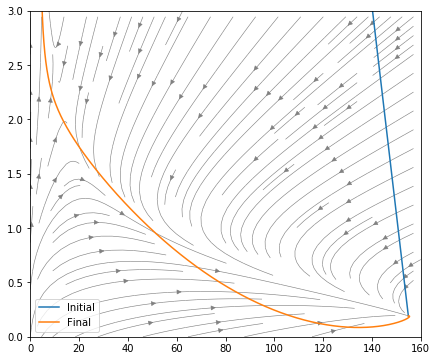

In [23]:
ts = np.linspace(-1, 1, 1000)

paths = [
    (m0, "Initial"),
    (m, "Final")
]

for p in paths:
    _m, _mlabel = p
    xs, vs = ff.evaluate(_m, ts)
    plt.plot(xs[:,0], xs[:,1], label=_mlabel)

X, Y = np.meshgrid(np.linspace(0, 160, 100), np.linspace(0, 3, 100))
vx,vy=system_a(X,Y); vx=vx; vy=vy
plt.streamplot(X,Y, vx, vy, density=1.2, linewidth=.6, color='gray');
plt.xlim(0, 160)
plt.ylim(0, 3)
plt.legend()

fig = mpl.pyplot.gcf()
fig.set_size_inches(7, 6)

### Gradient optimisation

In [29]:
e_xs

array([5.88007796e-03, 2.98246289e+01])

In [11]:
x_start = e_xb
x_end = e_xa

Nm = 1
Nq = Nm*60

m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nm,
                                    exclude_start_point=True, exclude_end_point=True)

quad_scheme = pyritz.quads.Q_clenshaw_curtis
qts, qws = quad_scheme(Nq)

ff = pyritz.funcs.CollocationFF(dim, fixed_start_point=x_start, fixed_end_point=x_end)
ff.initialise(Nm, qts)

compute_gradient=True
act = pyritz.Action(dim, ff, lagrangian, Nm, Nq, quadrature_scheme=quad_scheme,
                    lagrangian_args=compute_gradient)

def get_action(m, grad):
    opt.evals+=1
    if grad.size > 0:
        return act.compute(m, grad)
    else:
        return act.compute(m)

opt = nlopt.opt(nlopt.LD_SLSQP, np.size(m0))
opt.set_min_objective(get_action)
#opt.set_xtol_rel(1e-16)
#opt.set_abs_rel(1e-16)
#opt.set_ftol_rel(1e-12)
opt.set_ftol_abs(1e-16)
opt.evals = 0
m = opt.optimize(m0)

print(act.compute(m0))
print(act.compute(m))
print("Evals:", opt.evals)

#vals.append(act.compute(m))
#print(np.sqrt(np.var(vals)))

236.74413022415445
4.537854002379351
Evals: 70


In [33]:
ts = np.linspace(-1, 1, 3000)
fvals = ff.evaluate(m, ts)
ls = np.zeros(3000)
lagrangian(ls, None, None, fvals, ts, False)
", ".join(map(str, ls))

'3.02358220548251e-12, 0.044824049210390404, 0.08870350244270275, 0.13165253891459194, 0.1736850189423178, 0.21481451954459985, 0.2550543632931941, 0.2944176417785638, 0.3329172347764846, 0.37056582597649523, 0.4073759159559778, 0.4433598329426829, 0.47852974179732044, 0.5128976515593777, 0.5464754218298893, 0.5792747682089683, 0.61130726696247, 0.6425843590573237, 0.6731173536770285, 0.7029174313075899, 0.7319956464663449, 0.7603629301321604, 0.7880300919249805, 0.8150078220732127, 0.8413066932013322, 0.8669371619633637, 0.8919095705444136, 0.9162341480481899, 0.9399210117856427, 0.9629801684778414, 0.9854215153831944, 1.0072548413597815, 1.028489827868924, 1.0491360499287339, 1.069202977022229, 1.0886999739667544, 1.107636301747732, 1.1260211183223987, 1.1438634793966855, 1.1611723391775683, 1.1779565511058365, 1.194224868569762, 1.209985945603961, 1.2252483375736176, 1.2400205018479937, 1.2543107984634219, 1.2681274907781983, 1.281478746120058, 1.2943726364286476, 1.3068171388923133

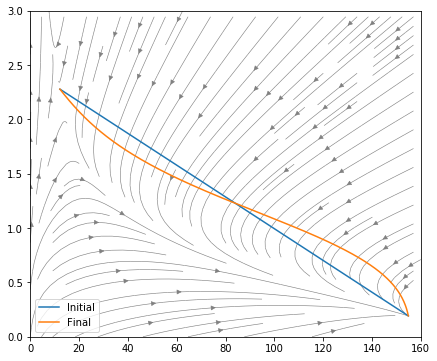

In [21]:
ts = np.linspace(-1, 1, 1000)

paths = [
    (m0, "Initial"),
    (m, "Final")
]

for p in paths:
    _m, _mlabel = p
    xs, vs = ff.evaluate(_m, ts)
    plt.plot(xs[:,0], xs[:,1], label=_mlabel)

xlim = (0, 160)
ylim = (0, 3)
    
X, Y = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
vx,vy=system_a(X,Y); vx=vx; vy=vy
plt.streamplot(X,Y, vx, vy, density=1.2, linewidth=.6, color='gray');
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
plt.legend()

fig = mpl.pyplot.gcf()
fig.set_size_inches(7, 6)

In [19]:
ts = quad_scheme(Nq)[0]
gvals = act.compute_lagrangian(m)[0]

ss = ""

for s, t in zip(gvals, ts):
    ss += "{%f,%f}," %(t,s)
ss

'{-1.000000,0.000000},{-0.999652,0.013520},{-0.998606,0.053363},{-0.996865,0.117443},{-0.994430,0.202484},{-0.991301,0.304298},{-0.987481,0.418128},{-0.982973,0.539013},{-0.977780,0.662135},{-0.971906,0.783109},{-0.965354,0.898191},{-0.958130,1.004387},{-0.950237,1.099479},{-0.941683,1.181968},{-0.932472,1.250971},{-0.922612,1.306083},{-0.912108,1.347252},{-0.900969,1.374659},{-0.889202,1.388644},{-0.876815,1.389666},{-0.863817,1.378305},{-0.850217,1.355284},{-0.836025,1.321521},{-0.821250,1.278181},{-0.805902,1.226711},{-0.789993,1.168865},{-0.773534,1.106697},{-0.756535,1.042514},{-0.739009,0.978806},{-0.720968,0.918141},{-0.702425,0.863043},{-0.683392,0.815867},{-0.663882,0.778674},{-0.643910,0.753123},{-0.623490,0.740391},{-0.602635,0.741122},{-0.581359,0.755409},{-0.559679,0.782803},{-0.537609,0.822349},{-0.515164,0.872636},{-0.492360,0.931863},{-0.469213,0.997914},{-0.445738,1.068436},{-0.421954,1.140929},{-0.397875,1.212838},{-0.373518,1.281657},{-0.348902,1.345035},{-0.324042,1

## Quasipotential

In [ ]:
def m0_provider(x_start, x_end, Nm, prev_m):
    ff.set_fixed_end_point(x_end)

    if not prev_m is None:
        return prev_m
    else:
        m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nm,
                                        exclude_start_point=True, exclude_end_point=True)
        return m0
    #if np.allclose(x_end, e_xb):
    #    m0 += (-1 + 2*np.random.random(len(m0)))*0.1 # Add some noise to initial path
    #return m0

x_start = e_xa

Nm = 8
Nq = Nm*10

qp_width = 2
qp_height = 2
xs = np.linspace(-1.2, 1.2, qp_width)
ys = np.linspace(-0.4,0.4, qp_height)

ff = pyritz.funcs.CollocationFF(Nm, dim, derivatives=1,
                               fixed_start_point=x_start,
                               fixed_end_point=x_end)
quad_scheme = pyritz.quads.Q_clenshaw_curtis
compute_gradient=True

qp = pyritz.utils.compute_quasipotential(xs, ys, Nm, Nq, x_start, lagrangian, ff, quad_scheme,
                      m0_provider, nlopt.LD_MMA, lagrangian_args=compute_gradient, xtol_rel=1e-12, maxeval=5000)

### Convergence

In [7]:
import warnings; warnings.simplefilter('ignore')

acs = []

for i in range(1, 32):
    x_start = e_xb
    x_end = e_xa

    Nm = i
    Nq = Nm*80

    m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nm,
                                        exclude_start_point=True, exclude_end_point=True)

    ff = pyritz.funcs.CollocationFF(Nm, dim, derivatives=1,
                                   fixed_start_point=x_start,
                                   fixed_end_point=x_end)

    quad_scheme = pyritz.quads.Q_clenshaw_curtis

    compute_gradient=True
    act = pyritz.Action(dim, ff, lagrangian, Nq, quad_scheme,
                        lagrangian_args=compute_gradient)

    def get_action(m, grad):
        if grad.size > 0:
            return act.compute(m, grad)
        else:
            return act.compute(m)

    opt = nlopt.opt(nlopt.LD_SLSQP, np.size(m0))
    opt.set_min_objective(get_action)
    opt.set_xtol_rel(1e-16)
    m = opt.optimize(m0)

    s = act.compute(m)
    
    # Compute accurate S
    
    act = pyritz.Action(dim, ff, lagrangian, Nq*40, quad_scheme,
                            lagrangian_args=compute_gradient)

    acc_s = act.compute(m)
    
    print("Nm:", Nm, "Nq:", Nq, "S:", s, "acc_S:", acc_s, "err_S:", np.abs(acc_s - s))
    
    acs.append( (Nm, Nq, s, m) )

Nm: 1 Nq: 80 S: 4.537879695106927 acc_S: 4.537875170470565 err_S: 4.524636361580292e-06
Nm: 2 Nq: 160 S: 4.168485269641047 acc_S: 4.168485269640804 err_S: 2.424727085781342e-13
Nm: 3 Nq: 240 S: 4.168301910354956 acc_S: 4.16830191035494 err_S: 1.5987211554602254e-14
Nm: 4 Nq: 320 S: 4.1682548465463025 acc_S: 4.168254846546285 err_S: 1.7763568394002505e-14
Nm: 5 Nq: 400 S: 4.168254204090128 acc_S: 4.168254204090158 err_S: 3.019806626980426e-14
Nm: 6 Nq: 480 S: 4.168254268601732 acc_S: 4.168254268601725 err_S: 7.105427357601002e-15
Nm: 7 Nq: 560 S: 4.168254206407428 acc_S: 4.168254206407477 err_S: 4.884981308350689e-14
Nm: 8 Nq: 640 S: 4.1682542180601505 acc_S: 4.168254218060164 err_S: 1.3322676295501878e-14
Nm: 9 Nq: 720 S: 4.168254273540614 acc_S: 4.168254273783465 err_S: 2.4285107258492644e-10
Nm: 10 Nq: 800 S: 4.168254199178311 acc_S: 4.168254199178342 err_S: 3.108624468950438e-14
Nm: 11 Nq: 880 S: 4.168254201788777 acc_S: 4.168254201788818 err_S: 4.085620730620576e-14
Nm: 12 Nq: 960 

In [14]:
import warnings; warnings.simplefilter('ignore')

def lagrangian_args_generator(Nm, Nq, m, function_family):
    m[:] += (-1 + 2*np.random.random(len(m)))*0.05 # Add some noise to initial path
    return True

x_start = e_xb
x_end = e_xa

Nms = np.arange(1, 32)
Nqs = Nms*80

m0 = pyritz.funcs.CollocationFF.get_straight_line_path(x_start, x_end, Nms[0],
                                    exclude_start_point=True, exclude_end_point=True)

ff = pyritz.funcs.CollocationFF(Nms[0], dim, derivatives=1,
                               fixed_start_point=x_start,
                               fixed_end_point=x_end)
quad_scheme = pyritz.quads.Q_clenshaw_curtis
compute_gradient=True

res = []
pyritz.utils.minimize_action_iteratively(Nms, Nqs, x_start, x_end, lagrangian, ff, quad_scheme, m0,
                           nlopt.LD_SLSQP, lagrangian_args=compute_gradient,
                           xtol_rel=1e-16, results=res,
                            lagrangian_args_generator=lagrangian_args_generator,
                            compute_accurate_S=True, compute_accurate_S_Nq_factor=40)

Nm: 1  Nq: 80  S: 4.537879695106831 acc_S: 4.537875170470671 err_S: 4.524636159963791e-06
Nm: 2  Nq: 160  S: 540.3390672739429 acc_S: 1156.3865740027209 err_S: 616.047506728778
Nm: 3  Nq: 240  S: 4.16830191035492 acc_S: 4.168301910354935 err_S: 1.509903313490213e-14
Nm: 4  Nq: 320  S: 4.1682548465462705 acc_S: 4.168254846546285 err_S: 1.4210854715202004e-14
Nm: 5  Nq: 400  S: 4.168254242032964 acc_S: 4.168254242032981 err_S: 1.7763568394002505e-14
Nm: 6  Nq: 480  S: 4.168254201475399 acc_S: 4.16825420147542 err_S: 2.042810365310288e-14
Nm: 7  Nq: 560  S: 4.1682541994698905 acc_S: 4.168254199469949 err_S: 5.861977570020827e-14
Nm: 8  Nq: 640  S: 4.168254200940127 acc_S: 4.168254200940174 err_S: 4.707345624410664e-14
Nm: 9  Nq: 720  S: 4.168254200612113 acc_S: 4.1682542006123455 err_S: 2.327027459614328e-13
Nm: 10  Nq: 800  S: 4.1682542133385825 acc_S: 4.1682542133386535 err_S: 7.105427357601002e-14
Nm: 11  Nq: 880  S: 4.16825419975737 acc_S: 4.168254869463642 err_S: 6.697062717719859e-0

MemoryError: 